In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
from matplotlib import font_manager, rc
from matplotlib.ticker import MaxNLocator

from IPython.display import Image # 이미지 삽입

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [25,15]
plt.rcParams['font.size'] = 25

In [3]:
# outliar 제거 함수 (IQR 설정)
def remove_out(*dataframes, remove_col) :
    for i, dataframe in enumerate(dataframes) :
        for k in remove_col :
            level_1q = dataframe[k].quantile(0.25)
            level_3q = dataframe[k].quantile(0.75)
            IQR = level_3q - level_1q
            rev_range = 10
            
            outliar_h = dataframe[k] >= level_3q + (rev_range * IQR)
            outliar_l = dataframe[k] <= level_1q - (rev_range * IQR)

            a=dataframe[outliar_h].index
            b=dataframe[outliar_l].index
            
            print(dataframe.name,":",[a,b],"\n")
            
            dataframe.drop(a, inplace=True)
            dataframe.drop(b, inplace=True)

# 풍향과 풍속을 풍벡터로 표현
def wind_vector(*dataframe):
    for data in dataframe :
        # 풍향을 라디안으로 변환
        theta = np.deg2rad(data.wind_dir)

        # 극 좌표에서 직교 좌표로 변환
        x = data.wind_speed * np.cos(theta)
        y = data.wind_speed * np.sin(theta)

        data['wind_vector_x'] = x
        data['wind_vector_y'] = y
        data.drop('wind_dir', axis=1, inplace=True)
        data.drop('wind_speed', axis=1, inplace=True)

# # 아림의 미세먼지 농도가 매우나쁨 이상일 때, airKorea의 미세먼지 농도의 평가
# def air_quality_label(pm25):
#     if pm25 <= 15:
#         return '좋음'
#     elif pm25 <= 35:
#         return '보통'
#     elif pm25 <= 75:
#         return '나쁨'
#     else:
#         return '매우 나쁨'

def air_quality_label(pm25):
    if pm25 <= 35:
        return '좋음,보통'
    else:
        return '나쁨,매우 나쁨'

In [5]:
# arim_data 1.01~1.15 Hour
OA200_2 = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
OA200_2['reg_date'] = OA200_2.reg_date.apply(pd.to_datetime)

OA200_1 = pd.read_csv('./OA200_1/OA2001_01.01~01.15.csv')
OA200_1['reg_date'] = OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 1.16~1.31 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')
airKorea_data_1['date'] = airKorea_data_1.date.apply(pd.to_datetime)

airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_01.01~01.15.csv')
airKorea_data_2['date'] = airKorea_data_2.date.apply(pd.to_datetime)

airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_01.01~01.15.csv')
airKorea_data_3['date'] = airKorea_data_3.date.apply(pd.to_datetime)

# 이름 설정
OA200_1.name = '학교'
OA200_2.name = '진주성'
airKorea_data_1.name = '상봉동'
airKorea_data_2.name = '상대동'
airKorea_data_3.name = '대안동'

# outliar 제거
remove_out(OA200_1, OA200_2, airKorea_data_1, airKorea_data_2, airKorea_data_3, remove_col=['pm25'])

# 1시간 단위로 측정 나누기
OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
airKorea_data_1_avg = airKorea_data_1.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_2_avg = airKorea_data_2.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_3_avg = airKorea_data_3.groupby([pd.Grouper(key='date', freq='H')]).mean()

# arim 데이터 수정
OA200_1_avg_76 = OA200_1_avg.loc[OA200_1_avg.loc[OA200_1_avg.pm25 >= 76].index]
OA200_2_avg_76 = OA200_2_avg.loc[OA200_2_avg.loc[OA200_2_avg.pm25 >= 76].index]
OA200_1_avg_76.pm25 -= 10.65
OA200_2_avg_76.pm25 -= 10.65

# arim 데이터 수정 후 대입
OA200_1_avg.loc[OA200_1_avg_76.index, 'pm25'] = OA200_1_avg_76['pm25']
OA200_2_avg.loc[OA200_2_avg_76.index, 'pm25'] = OA200_2_avg_76['pm25']

# 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
OA200_1_avg['air_quality_label'] = OA200_1_avg['pm25'].apply(lambda x: air_quality_label(x))
OA200_2_avg['air_quality_label'] = OA200_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_1_avg['air_quality_label'] = airKorea_data_1_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_2_avg['air_quality_label'] = airKorea_data_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_3_avg['air_quality_label'] = airKorea_data_3_avg['pm25'].apply(lambda x: air_quality_label(x))

# arim 데이터 풍향, 풍속 데이터 삽입
Sangbong = pd.read_csv("./weather/상봉동/2023-01.csv", encoding='cp949')
Sangbong['일시'] = Sangbong['일시'].apply(pd.to_datetime)
Sangbong_avg = Sangbong.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_2_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
OA200_2_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Jungchon = pd.read_csv("./weather/정촌면(학교근처)/2023-01.csv", encoding='cp949')
Jungchon['일시'] = Jungchon['일시'].apply(pd.to_datetime)
Jungchon_avg = Jungchon.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_1_avg['wind_dir'] = Jungchon_avg['풍향(16방위)']
OA200_1_avg['wind_speed'] = Jungchon_avg['풍속(m/s)']

# airKorea 데이터 온도, 습도, 풍향, 풍속 데이터 삽입
airKorea_data_1_avg['temp'] = Sangbong_avg['기온']
airKorea_data_1_avg['humi'] = Sangbong_avg['상대습도(%)']
airKorea_data_1_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
airKorea_data_1_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Sangdae = pd.read_csv("./weather/상대동/2023-01.csv", encoding='cp949')
Sangdae['일시'] = Sangdae['일시'].apply(pd.to_datetime)
Sangdae_avg = Sangdae.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_2_avg['temp'] = Sangdae_avg['기온']
airKorea_data_2_avg['humi'] = Sangdae_avg['상대습도(%)']
airKorea_data_2_avg['wind_dir'] = Sangdae_avg['풍향(16방위)']
airKorea_data_2_avg['wind_speed'] = Sangdae_avg['풍속(m/s)']

Daean = pd.read_csv("./weather/대안동/2023-01.csv", encoding='cp949')
Daean['일시'] = Daean['일시'].apply(pd.to_datetime)
Daean_avg = Daean.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_3_avg['temp'] = Daean_avg['기온']
airKorea_data_3_avg['humi'] = Daean_avg['상대습도(%)']
airKorea_data_3_avg['wind_dir'] = Daean_avg['풍향(16방위)']
airKorea_data_3_avg['wind_speed'] = Daean_avg['풍속(m/s)']

# OA200 데이터의 필요없는 no 열 삭제
OA200_1_avg = OA200_1_avg.drop('no', axis=1)
OA200_2_avg = OA200_2_avg.drop('no', axis=1)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# 참고로 Nan 값을 가진 대안동의 데이터를 소거 해주는 작업이 필요!
airKorea_data_1_avg = airKorea_data_1_avg.dropna(subset=['pm25'], axis=0)
airKorea_data_2_avg = airKorea_data_2_avg.dropna(subset=['pm25'], axis=0)
airKorea_data_3_avg = airKorea_data_3_avg.dropna(subset=['pm25'], axis=0)
OA200_1_avg = OA200_1_avg.dropna(subset=['pm25'], axis=0)
OA200_2_avg = OA200_2_avg.dropna(subset=['pm25'], axis=0)

# 가장 작은 airKorea_data의 인덱스와 나머지 데이터들의 인덱스 같게 만들어주기
idx = set(airKorea_data_1_avg.index).intersection(
    set(airKorea_data_2_avg.index),
    set(airKorea_data_3_avg.index),
    set(OA200_1_avg.index),
    set(OA200_2_avg.index)
)
airKorea_data_1_avg = airKorea_data_1_avg.reindex(idx)
airKorea_data_2_avg = airKorea_data_2_avg.reindex(idx)
airKorea_data_3_avg = airKorea_data_3_avg.reindex(idx)
OA200_1_avg = OA200_1_avg.reindex(idx)
OA200_2_avg = OA200_2_avg.reindex(idx)

# 수정 후 데이터 셋 확인
print("###################################\n"*5)
print("수정후")

# 풍벡터 삽입
wind_vector(OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg, airKorea_data_3_avg)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
airKorea_data_1_avg = airKorea_data_1_avg.sort_index()
airKorea_data_2_avg = airKorea_data_2_avg.sort_index()
airKorea_data_3_avg = airKorea_data_3_avg.sort_index()
OA200_1_avg = OA200_1_avg.sort_index()
OA200_2_avg = OA200_2_avg.sort_index()

학교 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

진주성 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

상봉동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

상대동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

대안동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_12208\4288841225.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12208\4288841225.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2023-01-01 01:00:00 to 2023-01-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               350 non-null    float64
 1   pm10               350 non-null    float64
 2   temp               350 non-null    float64
 3   humi               350 non-null    float64
 4   air_quality_label  359 non-null    object 
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 30.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2023-01-01 01:00:00 to 2023-01-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               350 non-null    float64
 1   pm10               350 non-null    float64
 2   temp               350 non-null    float64
 3   humi               350 non-null    float64
 4   air_quality_label  359 non-null    object 
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 30.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2023-01-01 01:00:00 to 2023-01-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               347 non-null    float64
 1   pm25               319 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2023-01-01 01:00:00 to 2023-01-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               357 non-null    float64
 1   pm25               357 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 2023-01-01 01:00:00 to 2023-01-15 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               158 non-null    float64
 1   pm25               297 non-null    float64
 2   air_quality_label  359 non-null    object 
 3   temp               359 non-null    float64
 4   humi               359 non-null    float64
 5   wind_dir           359 non-null    float64
 6   wind_speed         359 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.4+ KB


None

###################################
###################################
###################################
###################################
###################################

수정후
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-01-03 08:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               253 non-null    float64
 1   pm10               253 non-null    float64
 2   temp               253 non-null    float64
 3   humi               253 non-null    float64
 4   air_quality_label  253 non-null    object 
 5   wind_vector_x      253 non-null    float64
 6   wind_vector_y      253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-01-03 08:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               253 non-null    float64
 1   pm10               253 non-null    float64
 2   temp               253 non-null    float64
 3   humi               253 non-null    float64
 4   air_quality_label  253 non-null    object 
 5   wind_vector_x      253 non-null    float64
 6   wind_vector_y      253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-01-03 08:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               253 non-null    float64
 1   pm25               253 non-null    float64
 2   air_quality_label  253 non-null    object 
 3   temp               253 non-null    float64
 4   humi               253 non-null    float64
 5   wind_vector_x      253 non-null    float64
 6   wind_vector_y      253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-01-03 08:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               253 non-null    float64
 1   pm25               253 non-null    float64
 2   air_quality_label  253 non-null    object 
 3   temp               253 non-null    float64
 4   humi               253 non-null    float64
 5   wind_vector_x      253 non-null    float64
 6   wind_vector_y      253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-01-03 08:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               123 non-null    float64
 1   pm25               253 non-null    float64
 2   air_quality_label  253 non-null    object 
 3   temp               253 non-null    float64
 4   humi               253 non-null    float64
 5   wind_vector_x      253 non-null    float64
 6   wind_vector_y      253 non-null    float64
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


None

[[3.23797883e-01 6.76202117e-01]
 [2.98730765e-01 7.01269235e-01]
 [2.65509304e-01 7.34490696e-01]
 [2.43774937e-01 7.56225063e-01]
 [2.67058645e-01 7.32941355e-01]
 [2.85240125e-01 7.14759875e-01]
 [3.43805153e-01 6.56194847e-01]
 [4.72551922e-01 5.27448078e-01]
 [5.36616202e-01 4.63383798e-01]
 [6.13696435e-01 3.86303565e-01]
 [6.09908879e-01 3.90091121e-01]
 [4.19650095e-01 5.80349905e-01]
 [5.98803279e-01 4.01196721e-01]
 [5.08558468e-01 4.91441532e-01]
 [3.52491049e-01 6.47508951e-01]
 [2.43496378e-01 7.56503622e-01]
 [1.14097614e-01 8.85902386e-01]
 [6.60108369e-02 9.33989163e-01]
 [1.94647063e-02 9.80535294e-01]
 [2.13324011e-02 9.78667599e-01]
 [1.80613479e-02 9.81938652e-01]
 [7.65984164e-03 9.92340158e-01]
 [2.73754513e-03 9.97262455e-01]
 [3.71501924e-07 9.99999628e-01]
 [5.78639850e-09 9.99999994e-01]
 [1.18260475e-09 9.99999999e-01]
 [3.51414102e-09 9.99999996e-01]
 [1.39058498e-08 9.99999986e-01]
 [2.15709006e-08 9.99999978e-01]
 [6.47953793e-10 9.99999999e-01]
 [7.981499

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


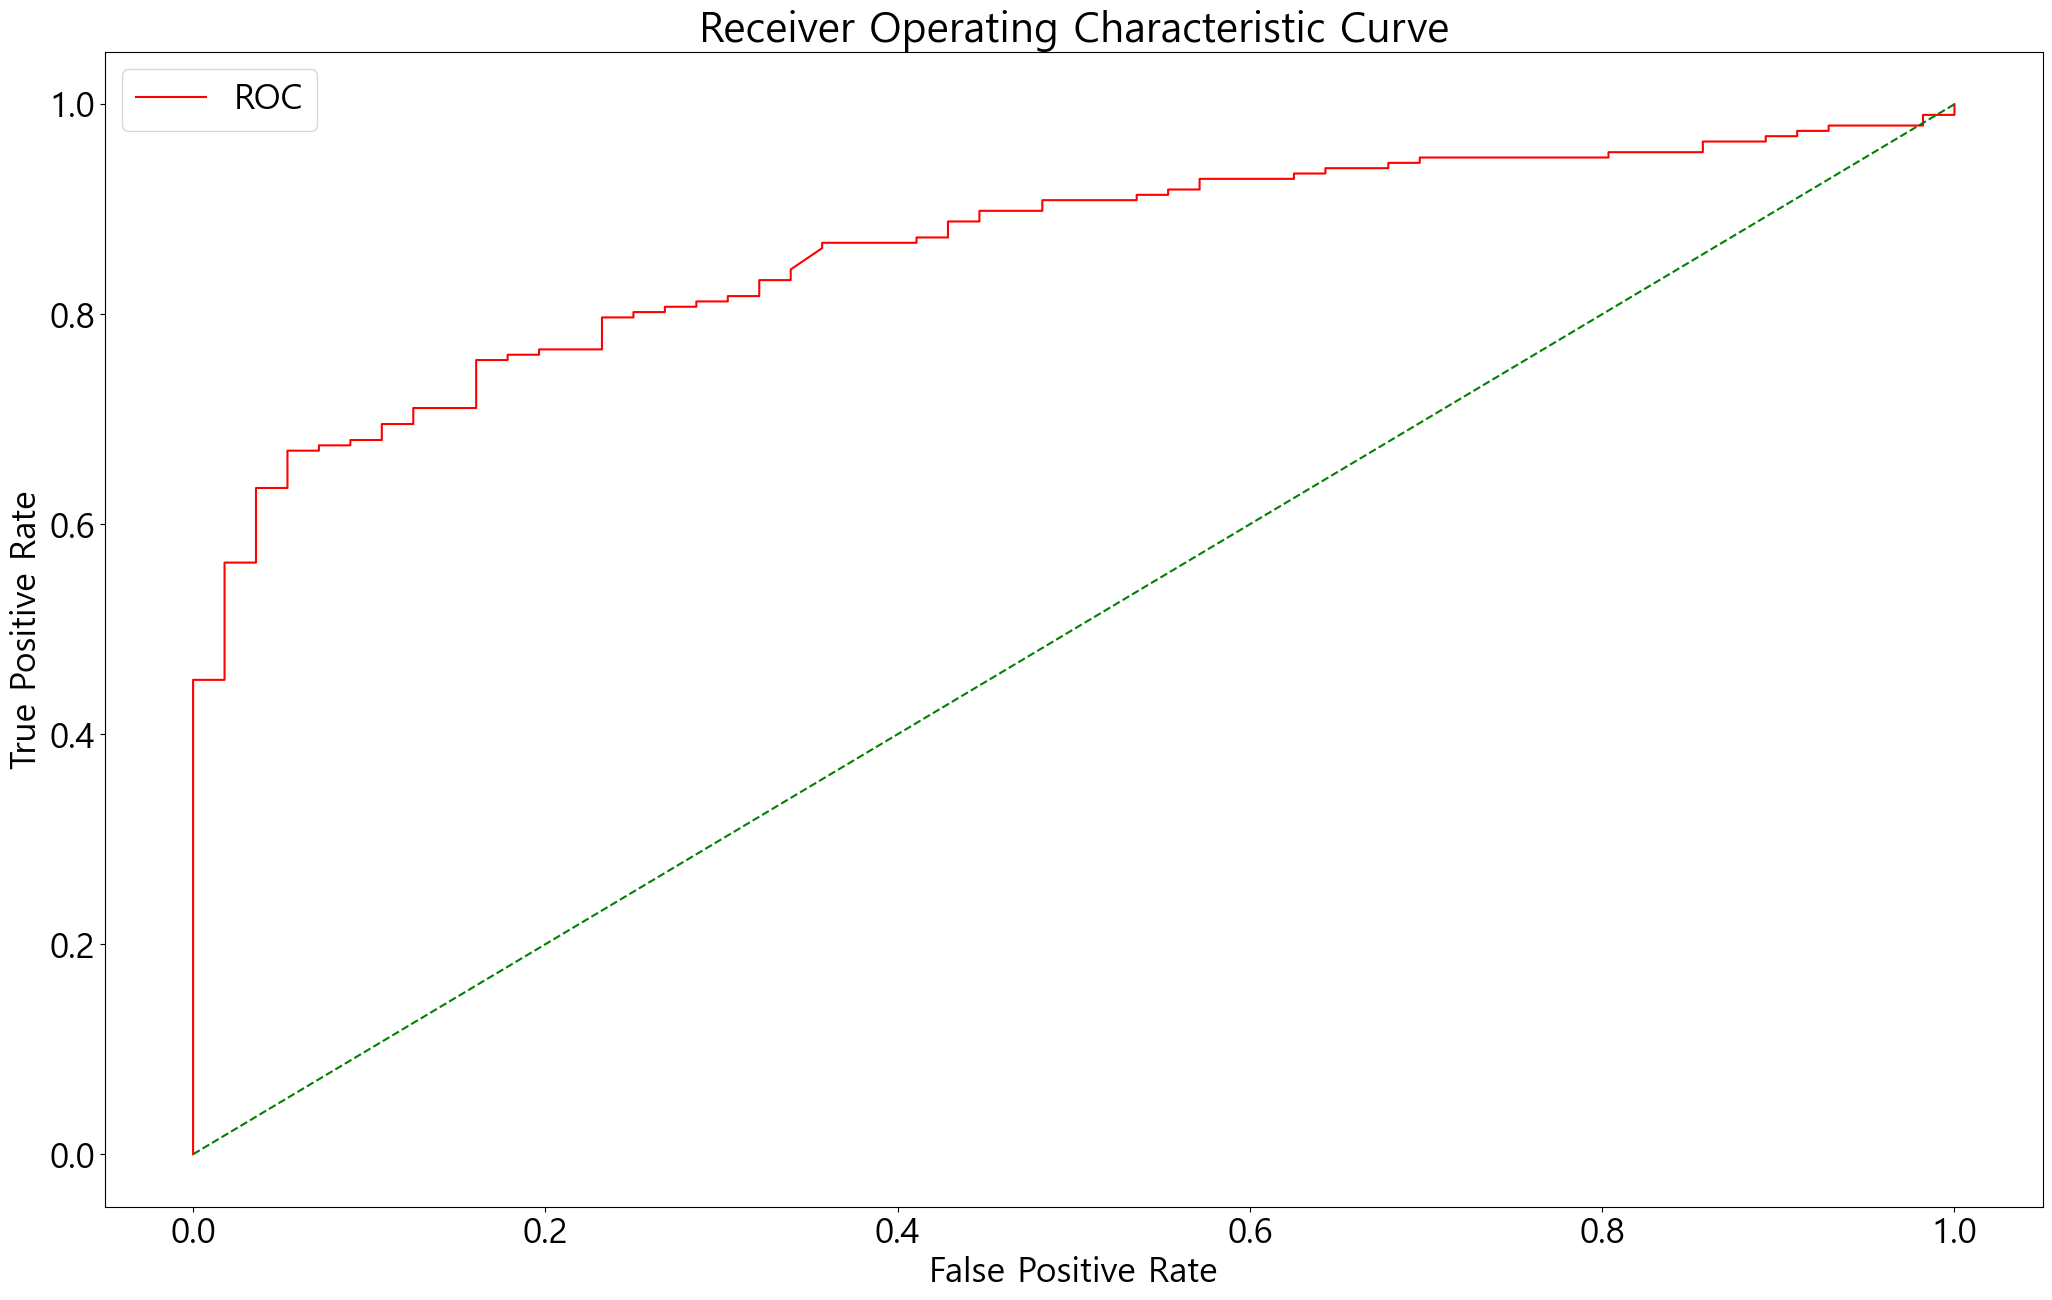

AUC: 0.8604967367657723


'\n다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함\n정밀도 : True로 예측한 것중 실제로 True인 비율\n재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율\nF1 Score : Precision과 Recall의 조화평균\n\n각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함\n\nauc 값은 1에 가까울 수록 좋은 성능을 나타내는데, 일반적으로 auc가 0.5보다 크면\n무작위로 선택한 것보단 괜찮다고 할 수 있지만, 상황에 따라 개선의 여지가 필요함.\n'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

X_train = pd.concat([OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg])
X_train = X_train.drop(columns=['pm10','pm25' ,'air_quality_label'])

y_train = pd.concat([OA200_1_avg['air_quality_label'], OA200_2_avg['air_quality_label'], airKorea_data_1_avg['air_quality_label'], airKorea_data_2_avg['air_quality_label']])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 예측을 수행 할 대상
X = airKorea_data_3_avg.drop(columns=['pm10','pm25', 'air_quality_label'])

# svc 적용
svc = SVC(kernel='rbf', probability=True) # 방사기저커널 (비선형)
svc.fit(X_train, y_train)

y_pred = svc.predict(X) # 예측 수행
y_pred_proba = svc.predict_proba(X)

y = airKorea_data_3_avg['air_quality_label'].tolist() # 비교할 대상

# 예측한 결과 출력
result = pd.DataFrame({'air_quality_label_pred': y_pred})
result.index = X.index
result['air_quality_label'] = y
result['probability'] = np.max(y_pred_proba, axis=1)
result.sort_index(inplace=True)

print(y_pred_proba)
print(result)

# confusion matrix
cm = confusion_matrix(y, y_pred)
print("\n              <Confusion matrix>\n\n",
      "                             실제값\n",
      "                    좋음,보통  나쁨,매우나쁨"
    "\n예| 좋음,보통       ",cm[0][0],"       ",cm[0][1],
    "\n측| 나쁨,매우 나쁨  ",cm[1][0],"       ",cm[1][1], "\n")

# accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

# precision
precision = precision_score(y, y_pred, average='macro')
print(f"Precision: {precision}")

# recall
recall = recall_score(y, y_pred, average='macro')
print(f"Recall: {recall}")

# f1 score
f1 = f1_score(y, y_pred, average='macro')
print(f"F1 Score: {f1}")

# roc curve
le = LabelEncoder()
# 좋음,보통을 0으로 나쁨,매우나쁨을 1로 설정해줘야 함
y_encoded = le.fit_transform(y)
fper, tper, thresholds = roc_curve(y_encoded, y_pred_proba[:, 1])
plot_roc_curve(fper, tper)

# auc
auc_score = auc(fper, tper)
print(f"AUC: {auc_score}")

"""
다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함
정밀도 : True로 예측한 것중 실제로 True인 비율
재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율
F1 Score : Precision과 Recall의 조화평균

각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함

auc 값은 1에 가까울 수록 좋은 성능을 나타내는데, 일반적으로 auc가 0.5보다 크면
무작위로 선택한 것보단 괜찮다고 할 수 있지만, 상황에 따라 개선의 여지가 필요함.
"""

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

X_train = pd.concat([OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg])
X_train = X_train.drop(columns=['pm10','pm25', 'air_quality_label'])

y_train = pd.concat([OA200_1_avg['air_quality_label'], OA200_2_avg['air_quality_label'], airKorea_data_1_avg['air_quality_label'], airKorea_data_2_avg['air_quality_label']])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 예측을 수행 할 대상
X = airKorea_data_3_avg.drop(columns=['pm10','pm25', 'air_quality_label'])

# svc 적용
svc = SVC(kernel='rbf', probability=True) # 방사기저커널 (비선형)
svc.fit(X_train, y_train)

y_pred = svc.predict(X) # 예측 수행
y_pred_proba = svc.predict_proba(X)

y = airKorea_data_3_avg['air_quality_label'].tolist() # 비교할 대상
# 예측한 결과 출력
result = pd.DataFrame({'air_quality_label_pred': y_pred})
result.index = X.index
result['air_quality_label'] = y
result['probability'] = np.max(y_pred_proba, axis=1)

result.sort_index(inplace=True)

print(result)

# confusion matrix
cm = confusion_matrix(y, y_pred)
print("\n             <Confusion matrix>\n\n",
      "                   실제값\n",
      "           좋음 보통 나쁨 매우나쁨"
    "\n예| 좋음    ",cm[0][0]," ",cm[0][1]," ",cm[0][2]," ",cm[0][3],
    "\n측| 보통    ",cm[1][0],"  ",cm[1][1],"  ",cm[1][2],"  ",cm[1][3],
    "\n값| 나쁨    ",cm[2][0]," ",cm[2][1]," ",cm[2][2]," ",cm[2][3],
    "\n  | 매우나쁨",cm[3][0]," ",cm[3][1]," ",cm[3][2]," ",cm[3][3],"\n")

# accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

# precision
precision = precision_score(y, y_pred, average='macro')
print(f"Precision: {precision}")

# recall
recall = recall_score(y, y_pred, average='macro')
print(f"Recall: {recall}")

# f1 score
f1 = f1_score(y, y_pred, average='macro')
print(f"F1 Score: {f1}")

"""
다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함
정밀도 : True로 예측한 것중 실제로 True인 비율
재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율
F1 Score : Precision과 Recall의 조화평균

각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함
"""

                    air_quality_label_pred air_quality_label  probability
date                                                                     
2023-01-01 03:00:00                     보통                보통     0.408668
2023-01-01 04:00:00                     보통                보통     0.401898
2023-01-01 05:00:00                     보통                보통     0.453655
2023-01-01 06:00:00                     보통                보통     0.432198
2023-01-01 07:00:00                     보통                보통     0.393507
...                                    ...               ...          ...
2023-01-15 19:00:00                     보통                좋음     0.404141
2023-01-15 20:00:00                     보통                좋음     0.383745
2023-01-15 21:00:00                     보통                좋음     0.383321
2023-01-15 22:00:00                     보통                좋음     0.371624
2023-01-15 23:00:00                     보통                좋음     0.373411

[253 rows x 3 columns]

             

'\n다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함\n정밀도 : True로 예측한 것중 실제로 True인 비율\n재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율\nF1 Score : Precision과 Recall의 조화평균\n\n각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함\n'

In [46]:
# 데이터 프레임 한번에 전체 다 보기
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result)

                    air_quality_label_pred air_quality_label
date                                                        
2023-01-01 03:00:00                     보통                나쁨
2023-01-01 04:00:00                     보통                좋음
2023-01-01 05:00:00                     보통                보통
2023-01-01 06:00:00                     보통                나쁨
2023-01-01 07:00:00                     보통                보통
2023-01-01 08:00:00                     보통                나쁨
2023-01-01 09:00:00                     보통                좋음
2023-01-01 10:00:00                     보통                나쁨
2023-01-01 11:00:00                     보통                좋음
2023-01-01 12:00:00                     보통                보통
2023-01-01 13:00:00                     나쁨                좋음
2023-01-01 14:00:00                     나쁨                보통
2023-01-01 16:00:00                     나쁨                좋음
2023-01-01 17:00:00                     나쁨                보통
2023-01-01 18:00:00     

In [ ]:
# CSV 파일로 결과를 추출하는 것
import os

folder_path = './svm'
if not os.path.exists(folder_path) :
    os.makedirs(folder_path, exist_ok=True)
    os.chmod(folder_path, 0o700)

# 파일 생성
    
result.to_csv('./svm/svm_result_01.01~01.15.csv', index=True, mode='w', encoding='cp949')

## 12월~4월 모든 데이터

In [9]:
# arim_data 12.01~12.15 Hour
f1_OA200_2 = pd.read_csv('./OA200_2/OA2002_12.01~12.15.csv')
f1_OA200_2['reg_date'] = f1_OA200_2.reg_date.apply(pd.to_datetime)

f1_OA200_1 = pd.read_csv('./OA200_1/OA2001_12.01~12.15.csv')
f1_OA200_1['reg_date'] = f1_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 12.01~12.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
f1_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_12.01~12.15.csv')
f1_airKorea_data_1['date'] = f1_airKorea_data_1.date.apply(pd.to_datetime)

f1_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_12.01~12.15.csv')
f1_airKorea_data_2['date'] = f1_airKorea_data_2.date.apply(pd.to_datetime)

f1_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_12.01~12.15.csv')
f1_airKorea_data_3['date'] = f1_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 12.16~12.31 Hour
s2_OA200_2 = pd.read_csv('./OA200_2/OA2002_12.16~12.31.csv')
s2_OA200_2['reg_date'] = s2_OA200_2.reg_date.apply(pd.to_datetime)

s2_OA200_1 = pd.read_csv('./OA200_1/OA2001_12.16~12.31.csv')
s2_OA200_1['reg_date'] = s2_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 12.16~12.31 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
s2_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_12.16~12.31.csv')
s2_airKorea_data_1['date'] = s2_airKorea_data_1.date.apply(pd.to_datetime)

s2_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_12.16~12.31.csv')
s2_airKorea_data_2['date'] = s2_airKorea_data_2.date.apply(pd.to_datetime)

s2_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_12.16~12.31.csv')
s2_airKorea_data_3['date'] = s2_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 1.01~1.15 Hour
t3_OA200_2 = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
t3_OA200_2['reg_date'] = t3_OA200_2.reg_date.apply(pd.to_datetime)

t3_OA200_1 = pd.read_csv('./OA200_1/OA2001_01.01~01.15.csv')
t3_OA200_1['reg_date'] = t3_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 1.01~1.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
t3_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')
t3_airKorea_data_1['date'] = t3_airKorea_data_1.date.apply(pd.to_datetime)

t3_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_01.01~01.15.csv')
t3_airKorea_data_2['date'] = t3_airKorea_data_2.date.apply(pd.to_datetime)

t3_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_01.01~01.15.csv')
t3_airKorea_data_3['date'] = t3_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 1.16~1.31 Hour
f4_OA200_2 = pd.read_csv('./OA200_2/OA2002_01.16~01.31.csv')
f4_OA200_2['reg_date'] = f4_OA200_2.reg_date.apply(pd.to_datetime)

f4_OA200_1 = pd.read_csv('./OA200_1/OA2001_01.16~01.31.csv')
f4_OA200_1['reg_date'] = f4_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 1.16~1.31 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
f4_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_01.16~01.31.csv')
f4_airKorea_data_1['date'] = f4_airKorea_data_1.date.apply(pd.to_datetime)

f4_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_01.16~01.31.csv')
f4_airKorea_data_2['date'] = f4_airKorea_data_2.date.apply(pd.to_datetime)

f4_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_01.16~01.31.csv')
f4_airKorea_data_3['date'] = f4_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 2.01~2.15 Hour
f5_OA200_2 = pd.read_csv('./OA200_2/OA2002_02.01~02.15.csv')
f5_OA200_2['reg_date'] = f5_OA200_2.reg_date.apply(pd.to_datetime)

f5_OA200_1 = pd.read_csv('./OA200_1/OA2001_02.01~02.15.csv')
f5_OA200_1['reg_date'] = f5_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 2.01~2.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
f5_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_02.01~02.15.csv')
f5_airKorea_data_1['date'] = f5_airKorea_data_1.date.apply(pd.to_datetime)

f5_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_02.01~02.15.csv')
f5_airKorea_data_2['date'] = f5_airKorea_data_2.date.apply(pd.to_datetime)

f5_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_02.01~02.15.csv')
f5_airKorea_data_3['date'] = f5_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 2.16~2.28 Hour
s6_OA200_2 = pd.read_csv('./OA200_2/OA2002_02.16~02.28.csv')
s6_OA200_2['reg_date'] = s6_OA200_2.reg_date.apply(pd.to_datetime)

s6_OA200_1 = pd.read_csv('./OA200_1/OA2001_02.16~02.28.csv')
s6_OA200_1['reg_date'] = s6_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 2.16~2.28 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
s6_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_02.16~02.28.csv')
s6_airKorea_data_1['date'] = s6_airKorea_data_1.date.apply(pd.to_datetime)

s6_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_02.16~02.28.csv')
s6_airKorea_data_2['date'] = s6_airKorea_data_2.date.apply(pd.to_datetime)

s6_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_02.16~02.28.csv')
s6_airKorea_data_3['date'] = s6_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 3.01~3.15 Hour
s7_OA200_2 = pd.read_csv('./OA200_2/OA2002_03.01~03.15.csv')
s7_OA200_2['reg_date'] = s7_OA200_2.reg_date.apply(pd.to_datetime)

s7_OA200_1 = pd.read_csv('./OA200_1/OA2001_03.01~03.15.csv')
s7_OA200_1['reg_date'] = s7_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 3.01~3.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
s7_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_03.01~03.15.csv')
s7_airKorea_data_1['date'] = s7_airKorea_data_1.date.apply(pd.to_datetime)

s7_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_03.01~03.15.csv')
s7_airKorea_data_2['date'] = s7_airKorea_data_2.date.apply(pd.to_datetime)

s7_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_03.01~03.15.csv')
s7_airKorea_data_3['date'] = s7_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 3.16~3.31 Hour
e_OA200_2 = pd.read_csv('./OA200_2/OA2002_03.16~03.31.csv')
e_OA200_2['reg_date'] = e_OA200_2.reg_date.apply(pd.to_datetime)

e_OA200_1 = pd.read_csv('./OA200_1/OA2001_03.16~03.31.csv')
e_OA200_1['reg_date'] = e_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 3.16~3.31 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
e_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_03.16~03.31.csv')
e_airKorea_data_1['date'] = e_airKorea_data_1.date.apply(pd.to_datetime)

e_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_03.16~03.31.csv')
e_airKorea_data_2['date'] = e_airKorea_data_2.date.apply(pd.to_datetime)

e_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_03.16~03.31.csv')
e_airKorea_data_3['date'] = e_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 4.01~4.15 Hour
n_OA200_2 = pd.read_csv('./OA200_2/OA2002_04.01~04.15.csv')
n_OA200_2['reg_date'] = n_OA200_2.reg_date.apply(pd.to_datetime)

n_OA200_1 = pd.read_csv('./OA200_1/OA2001_04.01~04.15.csv')
n_OA200_1['reg_date'] = n_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 4.01~4.15 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
n_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_04.01~04.15.csv')
n_airKorea_data_1['date'] = n_airKorea_data_1.date.apply(pd.to_datetime)

n_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_04.01~04.15.csv')
n_airKorea_data_2['date'] = n_airKorea_data_2.date.apply(pd.to_datetime)

n_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_04.01~04.15.csv')
n_airKorea_data_3['date'] = n_airKorea_data_3.date.apply(pd.to_datetime)

# arim_data 4.16~4.30 Hour
t10_OA200_2 = pd.read_csv('./OA200_2/OA2002_04.16~04.30.csv')
t10_OA200_2['reg_date'] = t10_OA200_2.reg_date.apply(pd.to_datetime)

t10_OA200_1 = pd.read_csv('./OA200_1/OA2001_04.16~04.30.csv')
t10_OA200_1['reg_date'] = t10_OA200_1.reg_date.apply(pd.to_datetime)

# airKorea_data 4.16~4.30 Hour, 상봉동 : 1, 상대동 : 2, 대안동 : 3
t10_airKorea_data_1 = pd.read_csv('./AirKorea_상봉동/AirKorea_04.16~04.30.csv')
t10_airKorea_data_1['date'] = t10_airKorea_data_1.date.apply(pd.to_datetime)

t10_airKorea_data_2 = pd.read_csv('./AirKorea_상대동/AirKorea_04.16~04.30.csv')
t10_airKorea_data_2['date'] = t10_airKorea_data_2.date.apply(pd.to_datetime)

t10_airKorea_data_3 = pd.read_csv('./AirKorea_대안동/AirKorea_04.16~04.30.csv')
t10_airKorea_data_3['date'] = t10_airKorea_data_3.date.apply(pd.to_datetime)

# 12.01~4.30 Hour
OA200_1 = pd.concat([f1_OA200_1, s2_OA200_1, t3_OA200_1, f4_OA200_1, f5_OA200_1, s6_OA200_1, s7_OA200_1, e_OA200_1, n_OA200_1, t10_OA200_1], ignore_index=True)
OA200_2 = pd.concat([f1_OA200_2, s2_OA200_2, t3_OA200_2, f4_OA200_2, f5_OA200_2, s6_OA200_2, s7_OA200_2, e_OA200_2, n_OA200_2, t10_OA200_2], ignore_index=True)
airKorea_data_1 = pd.concat([f1_airKorea_data_1, s2_airKorea_data_1, t3_airKorea_data_1, f4_airKorea_data_1, f5_airKorea_data_1, s6_airKorea_data_1, s7_airKorea_data_1, e_airKorea_data_1, n_airKorea_data_1, t10_airKorea_data_1], ignore_index=True)
airKorea_data_2 = pd.concat([f1_airKorea_data_2, s2_airKorea_data_2, t3_airKorea_data_2, f4_airKorea_data_2, f5_airKorea_data_2, s6_airKorea_data_2, s7_airKorea_data_2, e_airKorea_data_2, n_airKorea_data_2, t10_airKorea_data_2], ignore_index=True)
airKorea_data_3 = pd.concat([f1_airKorea_data_3, s2_airKorea_data_3, t3_airKorea_data_3, f4_airKorea_data_3, f5_airKorea_data_3, s6_airKorea_data_3, s7_airKorea_data_3, e_airKorea_data_3, n_airKorea_data_3, t10_airKorea_data_3], ignore_index=True)

# 이름 설정
OA200_1.name = '학교'
OA200_2.name = '진주성'
airKorea_data_1.name = '상봉동'
airKorea_data_2.name = '상대동'
airKorea_data_3.name = '대안동'

# outliar 제거
remove_out(OA200_1, OA200_2, airKorea_data_1, airKorea_data_2, airKorea_data_3, remove_col=['pm25'])

# 1시간 단위로 측정 나누기
OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
airKorea_data_1_avg = airKorea_data_1.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_2_avg = airKorea_data_2.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data_3_avg = airKorea_data_3.groupby([pd.Grouper(key='date', freq='H')]).mean()

# arim 데이터 수정
OA200_1_avg_76 = OA200_1_avg.loc[OA200_1_avg.loc[OA200_1_avg.pm25 >= 76].index]
OA200_2_avg_76 = OA200_2_avg.loc[OA200_2_avg.loc[OA200_2_avg.pm25 >= 76].index]
OA200_1_avg_76.pm25 -= 10.65
OA200_2_avg_76.pm25 -= 10.65

# arim 데이터 수정 후 대입
OA200_1_avg.loc[OA200_1_avg_76.index, 'pm25'] = OA200_1_avg_76['pm25']
OA200_2_avg.loc[OA200_2_avg_76.index, 'pm25'] = OA200_2_avg_76['pm25']

# 좋음, 보통, 나쁨, 매우나쁨 카데고리 분류
OA200_1_avg['air_quality_label'] = OA200_1_avg['pm25'].apply(lambda x: air_quality_label(x))
OA200_2_avg['air_quality_label'] = OA200_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_1_avg['air_quality_label'] = airKorea_data_1_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_2_avg['air_quality_label'] = airKorea_data_2_avg['pm25'].apply(lambda x: air_quality_label(x))
airKorea_data_3_avg['air_quality_label'] = airKorea_data_3_avg['pm25'].apply(lambda x: air_quality_label(x))

# arim 데이터 풍향, 풍속 데이터 삽입
Sangbong12 = pd.read_csv("./weather/상봉동/2022-12.csv", encoding='cp949')
Sangbong1 =  pd.read_csv("./weather/상봉동/2023-01.csv", encoding='cp949')
Sangbong2 =  pd.read_csv("./weather/상봉동/2023-02.csv", encoding='cp949')
Sangbong3 =  pd.read_csv("./weather/상봉동/2023-03.csv", encoding='cp949')
Sangbong4 =  pd.read_csv("./weather/상봉동/2023-04.csv", encoding='cp949')
Sangbong = pd.concat([Sangbong12, Sangbong1, Sangbong2, Sangbong3, Sangbong4], ignore_index=True)
Sangbong['일시'] = Sangbong['일시'].apply(pd.to_datetime)
Sangbong_avg = Sangbong.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_2_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
OA200_2_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Jungchon12 = pd.read_csv("./weather/정촌면(학교근처)/2022-12.csv", encoding='cp949')
Jungchon1 = pd.read_csv("./weather/정촌면(학교근처)/2023-01.csv", encoding='cp949')
Jungchon2 = pd.read_csv("./weather/정촌면(학교근처)/2023-02.csv", encoding='cp949')
Jungchon3 = pd.read_csv("./weather/정촌면(학교근처)/2023-03.csv", encoding='cp949')
Jungchon4 = pd.read_csv("./weather/정촌면(학교근처)/2023-04.csv", encoding='cp949')
Jungchon = pd.concat([Jungchon12, Jungchon1, Jungchon2, Jungchon3, Jungchon4], ignore_index=True)
Jungchon['일시'] = Jungchon['일시'].apply(pd.to_datetime)
Jungchon_avg = Jungchon.groupby([pd.Grouper(key='일시', freq='H')]).mean()
OA200_1_avg['wind_dir'] = Jungchon_avg['풍향(16방위)']
OA200_1_avg['wind_speed'] = Jungchon_avg['풍속(m/s)']

# airKorea 데이터 온도, 습도, 풍향, 풍속 데이터 삽입
airKorea_data_1_avg['temp'] = Sangbong_avg['기온']
airKorea_data_1_avg['humi'] = Sangbong_avg['상대습도(%)']
airKorea_data_1_avg['wind_dir'] = Sangbong_avg['풍향(16방위)']
airKorea_data_1_avg['wind_speed'] = Sangbong_avg['풍속(m/s)']

Sangdae12 = pd.read_csv("./weather/상대동/2022-12.csv", encoding='cp949')
Sangdae1 = pd.read_csv("./weather/상대동/2023-01.csv", encoding='cp949')
Sangdae2 = pd.read_csv("./weather/상대동/2023-02.csv", encoding='cp949')
Sangdae3 = pd.read_csv("./weather/상대동/2023-03.csv", encoding='cp949')
Sangdae4 = pd.read_csv("./weather/상대동/2023-04.csv", encoding='cp949')
Sangdae = pd.concat([Sangdae12, Sangdae1, Sangdae2, Sangdae3, Sangdae4], ignore_index=True)
Sangdae['일시'] = Sangdae['일시'].apply(pd.to_datetime)
Sangdae_avg = Sangdae.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_2_avg['temp'] = Sangdae_avg['기온']
airKorea_data_2_avg['humi'] = Sangdae_avg['상대습도(%)']
airKorea_data_2_avg['wind_dir'] = Sangdae_avg['풍향(16방위)']
airKorea_data_2_avg['wind_speed'] = Sangdae_avg['풍속(m/s)']

Daean12 = pd.read_csv("./weather/대안동/2022-12.csv", encoding='cp949')
Daean1 = pd.read_csv("./weather/대안동/2023-01.csv", encoding='cp949')
Daean2 = pd.read_csv("./weather/대안동/2023-02.csv", encoding='cp949')
Daean3 = pd.read_csv("./weather/대안동/2023-03.csv", encoding='cp949')
Daean4 = pd.read_csv("./weather/대안동/2023-04.csv", encoding='cp949')
Daean = pd.concat([Daean12, Daean1, Daean2, Daean3, Daean4], ignore_index=True)
Daean['일시'] = Daean['일시'].apply(pd.to_datetime)
Daean_avg = Daean.groupby([pd.Grouper(key='일시', freq='H')]).mean()
airKorea_data_3_avg['temp'] = Daean_avg['기온']
airKorea_data_3_avg['humi'] = Daean_avg['상대습도(%)']
airKorea_data_3_avg['wind_dir'] = Daean_avg['풍향(16방위)']
airKorea_data_3_avg['wind_speed'] = Daean_avg['풍속(m/s)']

# OA200 데이터의 필요없는 no 열 삭제
OA200_1_avg = OA200_1_avg.drop('no', axis=1)
OA200_2_avg = OA200_2_avg.drop('no', axis=1)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# 참고로 Nan 값을 가진 대안동의 데이터를 소거 해주는 작업이 필요!
airKorea_data_1_avg = airKorea_data_1_avg.dropna(subset=['pm25','temp','humi','wind_dir','wind_speed'], axis=0)
airKorea_data_2_avg = airKorea_data_2_avg.dropna(subset=['pm25','temp','humi','wind_dir','wind_speed'], axis=0)
airKorea_data_3_avg = airKorea_data_3_avg.dropna(subset=['pm25','temp','humi','wind_dir','wind_speed'], axis=0)
OA200_1_avg = OA200_1_avg.dropna(subset=['pm25','temp','humi','wind_dir','wind_speed'], axis=0)
OA200_2_avg = OA200_2_avg.dropna(subset=['pm25','temp','humi','wind_dir','wind_speed'], axis=0)

# 가장 작은 airKorea_data의 인덱스와 나머지 데이터들의 인덱스 같게 만들어주기
idx = set(airKorea_data_1_avg.index).intersection(
    set(airKorea_data_2_avg.index),
    set(airKorea_data_3_avg.index),
    set(OA200_1_avg.index),
    set(OA200_2_avg.index)
)
airKorea_data_1_avg = airKorea_data_1_avg.reindex(idx)
airKorea_data_2_avg = airKorea_data_2_avg.reindex(idx)
airKorea_data_3_avg = airKorea_data_3_avg.reindex(idx)
OA200_1_avg = OA200_1_avg.reindex(idx)
OA200_2_avg = OA200_2_avg.reindex(idx)

# 수정 후 데이터 셋 확인
print("###################################\n"*5)
print("수정후")

# 풍벡터 삽입
wind_vector(OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg, airKorea_data_3_avg)

# 일단 데이터 셋 확인
display(OA200_1_avg.info())
display(OA200_2_avg.info())
display(airKorea_data_1_avg.info())
display(airKorea_data_2_avg.info())
display(airKorea_data_3_avg.info())

# index 정렬이 안되서 출력이 돼 그래프가 이상하게 그려져 적용시킴
airKorea_data_1_avg = airKorea_data_1_avg.sort_index()
airKorea_data_2_avg = airKorea_data_2_avg.sort_index()
airKorea_data_3_avg = airKorea_data_3_avg.sort_index()
OA200_1_avg = OA200_1_avg.sort_index()
OA200_2_avg = OA200_2_avg.sort_index()

학교 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

진주성 : [Int64Index([12405, 89945, 103922, 127010, 211407, 211420], dtype='int64'), Int64Index([], dtype='int64')] 

상봉동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

상대동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 

대안동 : [Int64Index([], dtype='int64'), Int64Index([], dtype='int64')] 



C:\Users\ASUS\AppData\Local\Temp\ipykernel_12208\4077411297.py:189: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_2_avg = OA200_2.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_12208\4077411297.py:190: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  OA200_1_avg = OA200_1.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3623 entries, 2022-12-01 01:00:00 to 2023-04-30 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               3581 non-null   float64
 1   pm10               3581 non-null   float64
 2   temp               3581 non-null   float64
 3   humi               3581 non-null   float64
 4   air_quality_label  3623 non-null   object 
 5   wind_dir           3564 non-null   float64
 6   wind_speed         3564 non-null   float64
dtypes: float64(6), object(1)
memory usage: 355.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3623 entries, 2022-12-01 01:00:00 to 2023-04-30 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               3573 non-null   float64
 1   pm10               3573 non-null   float64
 2   temp               3573 non-null   float64
 3   humi               3573 non-null   float64
 4   air_quality_label  3623 non-null   object 
 5   wind_dir           3580 non-null   float64
 6   wind_speed         3580 non-null   float64
dtypes: float64(6), object(1)
memory usage: 355.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3623 entries, 2022-12-01 01:00:00 to 2023-04-30 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               3515 non-null   float64
 1   pm25               3406 non-null   float64
 2   air_quality_label  3623 non-null   object 
 3   temp               3580 non-null   float64
 4   humi               3580 non-null   float64
 5   wind_dir           3580 non-null   float64
 6   wind_speed         3580 non-null   float64
dtypes: float64(6), object(1)
memory usage: 226.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3623 entries, 2022-12-01 01:00:00 to 2023-04-30 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               3535 non-null   float64
 1   pm25               3528 non-null   float64
 2   air_quality_label  3623 non-null   object 
 3   temp               3580 non-null   float64
 4   humi               3580 non-null   float64
 5   wind_dir           3580 non-null   float64
 6   wind_speed         3580 non-null   float64
dtypes: float64(6), object(1)
memory usage: 226.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3623 entries, 2022-12-01 01:00:00 to 2023-04-30 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               3306 non-null   float64
 1   pm25               3493 non-null   float64
 2   air_quality_label  3623 non-null   object 
 3   temp               3580 non-null   float64
 4   humi               3580 non-null   float64
 5   wind_dir           3580 non-null   float64
 6   wind_speed         3580 non-null   float64
dtypes: float64(6), object(1)
memory usage: 226.4+ KB


None

###################################
###################################
###################################
###################################
###################################

수정후
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2023-03-20 20:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               3173 non-null   float64
 1   pm10               3173 non-null   float64
 2   temp               3173 non-null   float64
 3   humi               3173 non-null   float64
 4   air_quality_label  3173 non-null   object 
 5   wind_vector_x      3173 non-null   float64
 6   wind_vector_y      3173 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2023-03-20 20:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm25               3173 non-null   float64
 1   pm10               3173 non-null   float64
 2   temp               3173 non-null   float64
 3   humi               3173 non-null   float64
 4   air_quality_label  3173 non-null   object 
 5   wind_vector_x      3173 non-null   float64
 6   wind_vector_y      3173 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2023-03-20 20:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               3170 non-null   float64
 1   pm25               3173 non-null   float64
 2   air_quality_label  3173 non-null   object 
 3   temp               3173 non-null   float64
 4   humi               3173 non-null   float64
 5   wind_vector_x      3173 non-null   float64
 6   wind_vector_y      3173 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2023-03-20 20:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               3171 non-null   float64
 1   pm25               3173 non-null   float64
 2   air_quality_label  3173 non-null   object 
 3   temp               3173 non-null   float64
 4   humi               3173 non-null   float64
 5   wind_vector_x      3173 non-null   float64
 6   wind_vector_y      3173 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3173 entries, 2023-03-20 20:00:00 to 2023-01-12 15:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pm10               2963 non-null   float64
 1   pm25               3173 non-null   float64
 2   air_quality_label  3173 non-null   object 
 3   temp               3173 non-null   float64
 4   humi               3173 non-null   float64
 5   wind_vector_x      3173 non-null   float64
 6   wind_vector_y      3173 non-null   float64
dtypes: float64(6), object(1)
memory usage: 198.3+ KB


None

[[0.11619234 0.88380766]
 [0.13663583 0.86336417]
 [0.12374447 0.87625553]
 ...
 [0.12813011 0.87186989]
 [0.14488898 0.85511102]
 [0.15344708 0.84655292]]
                    air_quality_label_pred air_quality_label  probability
date                                                                     
2022-12-01 02:00:00                  좋음,보통             좋음,보통     0.883808
2022-12-01 03:00:00                  좋음,보통             좋음,보통     0.863364
2022-12-01 04:00:00                  좋음,보통             좋음,보통     0.876256
2022-12-01 05:00:00                  좋음,보통             좋음,보통     0.861211
2022-12-01 06:00:00                  좋음,보통             좋음,보통     0.855344
...                                    ...               ...          ...
2023-04-30 19:00:00                  좋음,보통             좋음,보통     0.892089
2023-04-30 20:00:00                  좋음,보통             좋음,보통     0.883586
2023-04-30 21:00:00                  좋음,보통             좋음,보통     0.871870
2023-04-30 22:00:00           

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


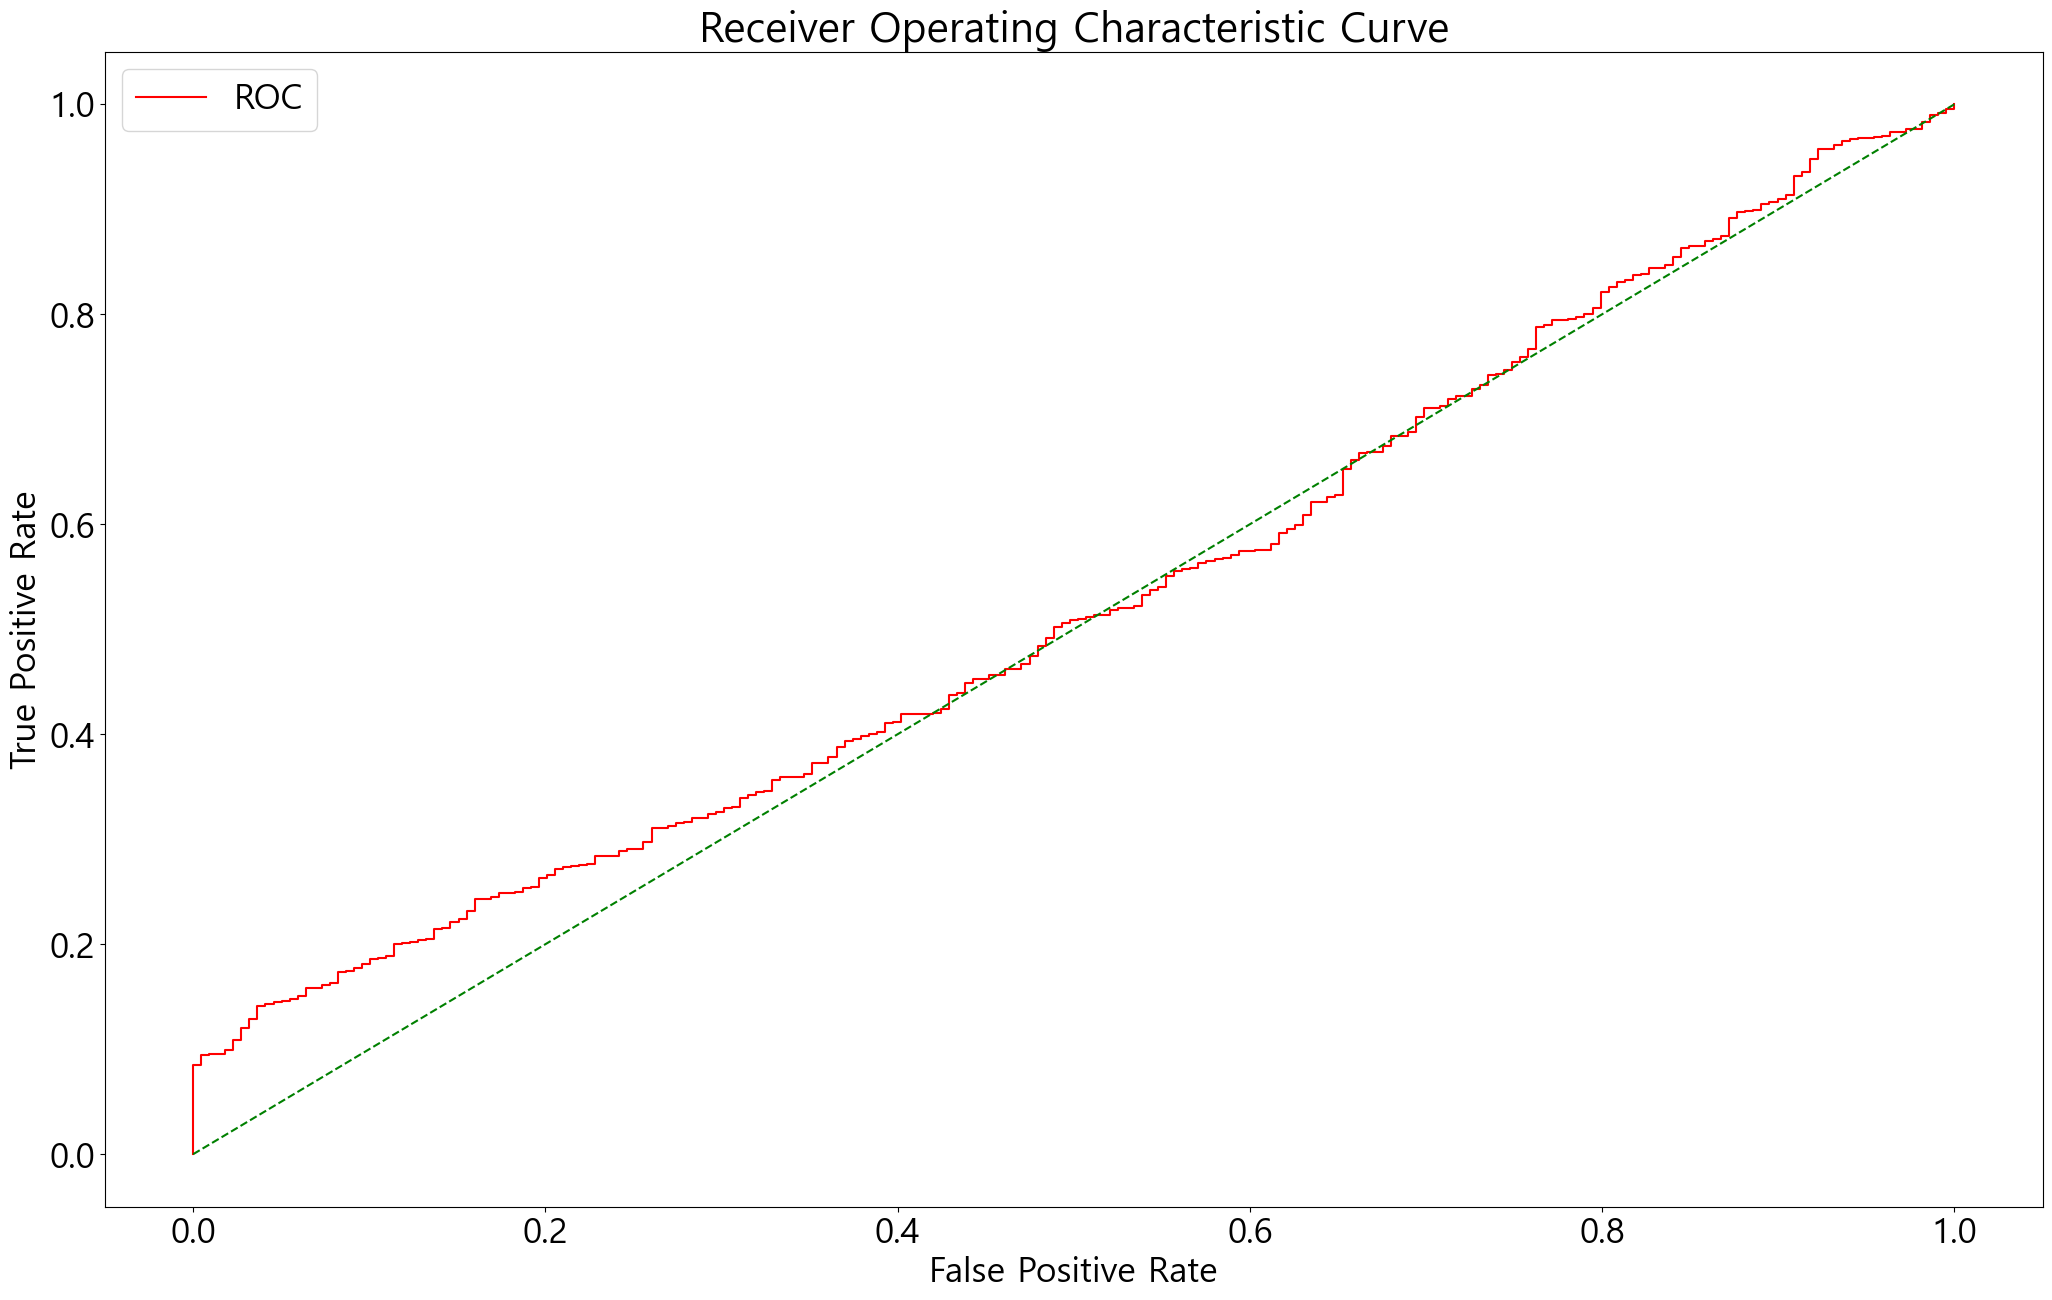

AUC: 0.5241619597913827


'\n다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함\n정밀도 : True로 예측한 것중 실제로 True인 비율\n재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율\nF1 Score : Precision과 Recall의 조화평균\n\n각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함\n\nauc 값은 1에 가까울 수록 좋은 성능을 나타내는데, 일반적으로 auc가 0.5보다 크면\n무작위로 선택한 것보단 괜찮다고 할 수 있지만, 상황에 따라 개선의 여지가 필요함.\n'

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

X_train = pd.concat([OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg])
X_train = X_train.drop(columns=['pm10','pm25' ,'air_quality_label'])

y_train = pd.concat([OA200_1_avg['air_quality_label'], OA200_2_avg['air_quality_label'], airKorea_data_1_avg['air_quality_label'], airKorea_data_2_avg['air_quality_label']])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 예측을 수행 할 대상
X = airKorea_data_3_avg.drop(columns=['pm10','pm25', 'air_quality_label'])

# svc 적용
svc = SVC(kernel='rbf', probability=True) # 방사기저커널 (비선형)
svc.fit(X_train, y_train)

y_pred = svc.predict(X) # 예측 수행
y_pred_proba = svc.predict_proba(X)

y = airKorea_data_3_avg['air_quality_label'].tolist() # 비교할 대상

# 예측한 결과 출력
result = pd.DataFrame({'air_quality_label_pred': y_pred})
result.index = X.index
result['air_quality_label'] = y
result['probability'] = np.max(y_pred_proba, axis=1)
result.sort_index(inplace=True)

print(y_pred_proba)
print(result)

# confusion matrix
cm = confusion_matrix(y, y_pred)
print("\n              <Confusion matrix>\n\n",
      "                             실제값\n",
      "                    좋음,보통  나쁨,매우나쁨"
    "\n예| 좋음,보통       ",cm[0][0],"       ",cm[0][1],
    "\n측| 나쁨,매우 나쁨  ",cm[1][0],"       ",cm[1][1], "\n")

# accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

# precision
precision = precision_score(y, y_pred, average='macro')
print(f"Precision: {precision}")

# recall
recall = recall_score(y, y_pred, average='macro')
print(f"Recall: {recall}")

# f1 score
f1 = f1_score(y, y_pred, average='macro')
print(f"F1 Score: {f1}")

# roc curve
le = LabelEncoder()
# 좋음,보통을 0으로 나쁨,매우나쁨을 1로 설정해줘야 함
y_encoded = le.fit_transform(y)
fper, tper, thresholds = roc_curve(y_encoded, y_pred_proba[:, 1])
plot_roc_curve(fper, tper)

# auc
auc_score = auc(fper, tper)
print(f"AUC: {auc_score}")

"""
다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함
정밀도 : True로 예측한 것중 실제로 True인 비율
재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율
F1 Score : Precision과 Recall의 조화평균

각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함

auc 값은 1에 가까울 수록 좋은 성능을 나타내는데, 일반적으로 auc가 0.5보다 크면
무작위로 선택한 것보단 괜찮다고 할 수 있지만, 상황에 따라 개선의 여지가 필요함.
"""

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

X_train = pd.concat([OA200_1_avg, OA200_2_avg, airKorea_data_1_avg, airKorea_data_2_avg])
X_train = X_train.drop(columns=['pm10','pm25', 'air_quality_label'])

y_train = pd.concat([OA200_1_avg['air_quality_label'], OA200_2_avg['air_quality_label'], airKorea_data_1_avg['air_quality_label'], airKorea_data_2_avg['air_quality_label']])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 예측을 수행 할 대상
X = airKorea_data_3_avg.drop(columns=['pm10','pm25', 'air_quality_label'])

# svc 적용
svc = SVC(kernel='rbf', probability=True) # 방사기저커널 (비선형)
svc.fit(X_train, y_train)

y_pred = svc.predict(X) # 예측 수행
y_pred_proba = svc.predict_proba(X)

y = airKorea_data_3_avg['air_quality_label'].tolist() # 비교할 대상
# 예측한 결과 출력
result = pd.DataFrame({'air_quality_label_pred': y_pred})
result.index = X.index
result['air_quality_label'] = y
result['probability'] = np.max(y_pred_proba, axis=1)

result.sort_index(inplace=True)

print(result)

# confusion matrix
cm = confusion_matrix(y, y_pred)
print("\n             <Confusion matrix>\n\n",
      "                   실제값\n",
      "           좋음 보통 나쁨 매우나쁨"
    "\n예| 좋음    ",cm[0][0]," ",cm[0][1]," ",cm[0][2]," ",cm[0][3],
    "\n측| 보통    ",cm[1][0],"  ",cm[1][1],"  ",cm[1][2],"  ",cm[1][3],
    "\n값| 나쁨    ",cm[2][0]," ",cm[2][1]," ",cm[2][2]," ",cm[2][3],
    "\n  | 매우나쁨",cm[3][0]," ",cm[3][1]," ",cm[3][2]," ",cm[3][3],"\n")

# accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

# precision
precision = precision_score(y, y_pred, average='macro')
print(f"Precision: {precision}")

# recall
recall = recall_score(y, y_pred, average='macro')
print(f"Recall: {recall}")

# f1 score
f1 = f1_score(y, y_pred, average='macro')
print(f"F1 Score: {f1}")

"""
다중 클래스는 OvR(One-vs.-Rest)문제로 자기 클래스는 Positive, 나머지는 모두 Negative로 하여 계산함
정밀도 : True로 예측한 것중 실제로 True인 비율
재현율 : 실제값이 True인 것중 모델이 True로 분류한 비율
F1 Score : Precision과 Recall의 조화평균

각각 구한 정밀도, 재현율, F1 Score를 평균내서 결과를 출력함
"""

In [ ]:
# CSV 파일로 결과를 추출하는 것
import os

folder_path = './svm'
if not os.path.exists(folder_path) :
    os.makedirs(folder_path, exist_ok=True)
    os.chmod(folder_path, 0o700)

# 파일 생성
    
result.to_csv('./svm/svm_result_12월~4월.csv', index=True, mode='w', encoding='cp949')